# Implementing ReAct algorithm from scratch with WatsonX 

**Authors:** Onkar Bharadwaj, Prattyush Mangal, Bing Zhang, Shubhi Asthana

In this tutorial, you will learn about the ReAct design pattern and its essentials, you will implement ReAct from the ground up and be introduced to techniques to level up ReAct for more complex use cases and production ready settings.

## 1. Read Before ReAct-ing <a class="anchor" id="step1"></a>

ReAct design pattern can be intuitively understood as a sequence of thoughts and actions [\[1\]](#footnotes). Given a problem, you iteratively think about the next action based on the current state, perform the corresponding action, and getting a response.

An important ingredient of ReAct is its dynamic nature. The path to solution gets revealed one step at a time. While its dynamic nature is powerful because it can adapt based on the current state, it needs to be applied carefully. Whenever a use-case can be expressed as a deterministic flow (linear or branched with if-else) involving LLM calls then the first choice should be to implement it deterministically instead of using ReAct. Doing this increases reliability, maintainability, and ease of evaluations. This is especially true for enterprise use-cases which need to satisfy high standards of quality.

If the use-case requires a dynamic flow, then we can consider using ReAct. ReAct is commonly utilized and abstracted away in popular agentic frameworks. Adding layers of abstractions with agentic frameworks often makes it opaque, difficult to debug, and less flexible. 

In this cookbook we build it up from the ground up, demonstrating its operation and low-complexity. This should enable developers to allocate their time to evaluating the effectiveness of the ReAct pattern for their usecase, and implementing custom functionality to achieve better accuracy and robustness. Once a developer is confident that ReAct works ground-up, a framework can always be adopted more seamlessly.

Typically, the ReAct pattern operates on tools and actions to be executed to deliver on the user's requests and intents, thus before starting any ReAct implementation, it is critical to make sure there is a need for it, there is data to evaluate its performance, and there are appropriate tools available.

#### 1.1 Well, I thought ReAct was something else? I have seen the popular prompts.

At its core, ReAct is Reason and Action (followed by reasoning based on observing the results of executing the actions). It is not tied to a prompt. A developer can implement this pattern in any manner with any prompt or sequence of prompts - so long as they are willing to evaluate performance based on the use case and data provided. Different LLMs may perform better with different prompts. Also at times, a different way of implementing could present the developer with a chance to optimize its performance in different ways, which we will discuss in this notebook.

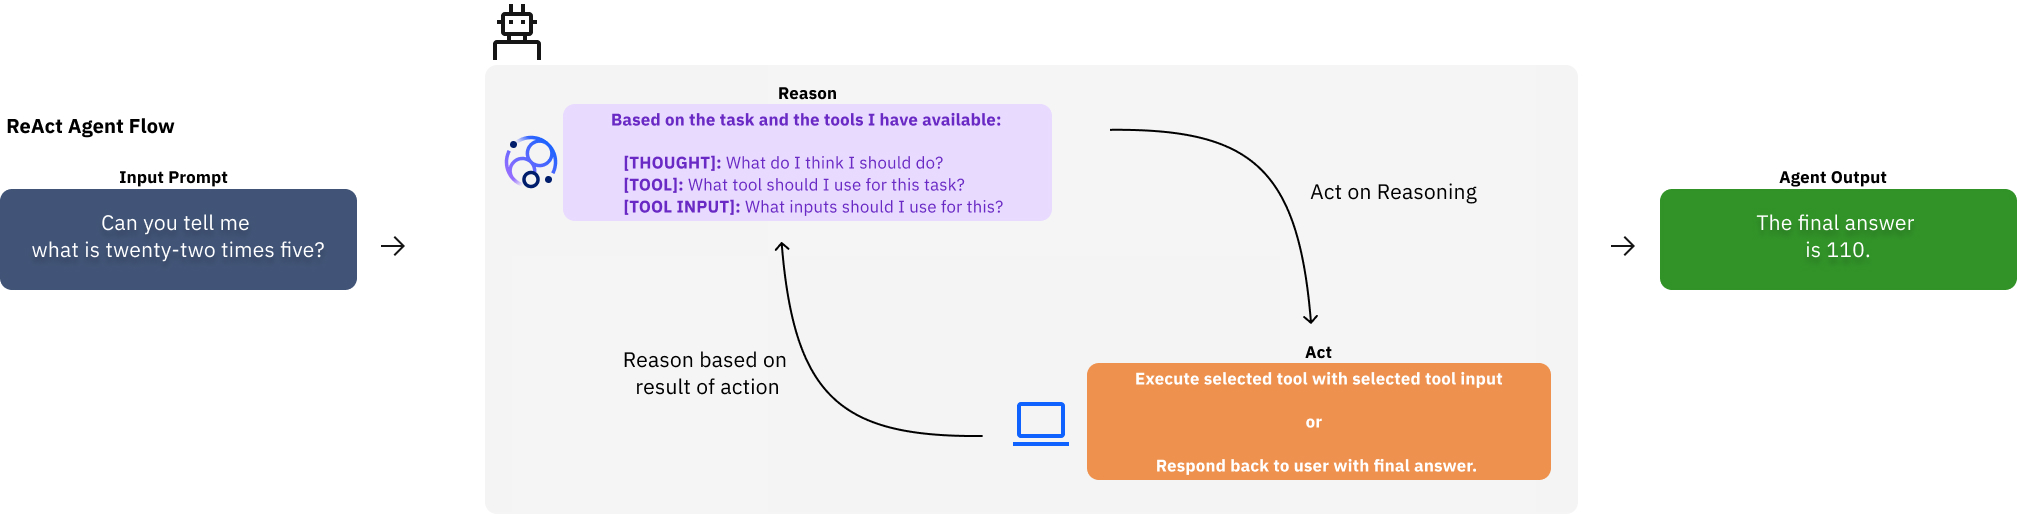

## 2. Essentials of ReAct <a class="anchor" id="step2"></a>

ReAct can be implemented in a variety of ways with different levels of complexity. However, some key ingredients remain common, and we introduce them in greater detail in the coming sections:

1. Well-specified set of actions or tools.
2. Environment to execute relevant tools.
3. An alternating flow of reason and action starting with a user query.
4. Additional use-case specific guidelines in the initial context.
5. (For smaller and efficient LLMs) Constrained decoding or alternate strategies for increased control and reliability.

### 2.1 Well-specified set of actions and tools.

Tools are the LLM's interfaces to the digital world. Just as well-defined and described tools enable humans to select and use the right tool for the job, a similarly well-defined toolset can enable the LLM or Agent to be more accurate in its execution. 

To improve the liklihood of the relevant tools being selected by the ReAct algorithm, all possible tools that an LLM can choose from should:
- Have descriptive names.
- Have well-defined uses and applications, specified through semantic descriptions of the tools.
- Be accompanied with a clear and descriptive parameter schema, with descriptions for each parameter. 

To further improve the changes of accurate operation, developers should consider toolsets which are narrow, and non-overlapping so that there is clarity for the LLM when choosing the action.

### 2.2 Ability to execute actions safely

When the tool is selected by the ReAct algorithm to be executed, there should be a safe, contained environment to execute the tool. Generative AI can hallucinate and a developer should be wary of this. 

Developers should consider whether write and delete operations should be equipped as tools for autonomous agents based on their use cases and business requirements. 

### 2.3 An alternating flow of reason and action starting with a user query

ReAct is simply an alternating flow of reason and action to respond to a user's query and can be implemented with different prompts to the LLMs. Below is a **pseudo-code** expressing the ReAct algorithm, and we will provide simple implementations later in the guide.

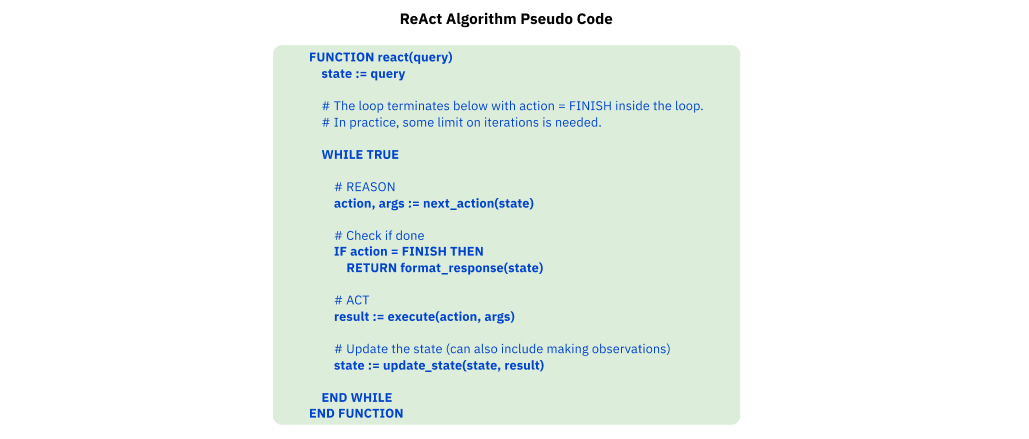

### 2.4 Additional use-case-specific guidelines in the initial context

The initial context (e.g., the system prompt) defines the domain, environment and tools available to the LLM/Agent. Defining clear objectives and explicitly prompting the models to perform iterative reasoning (think step-by-step) can enable the model to perform more accurately.  Developers can specify additional guidelines tailored to the tasks that ReAct implementation is expected to handle. 

For example:
- Providing context that incoming tasks will involve customer service, code generation, etc.
- Defining expected behaviors and behaviors to be avoided such as being to verbose or rude.

However, it’s important to note that LLMs may not strictly follow every guideline. 

In-context learning, through few-shot examples, should be utilized to provide extra information to LLMs about tool usage and expected communication patterns. Well-chosen examples can significantly improve performance. Moreover, these examples reinforce system guidelines more effectively than explicitly stating rules in the prompt.

Below is an example of extending a system prompt with few shot example to demonstrate desired behaviours and response patterns from the LLM:
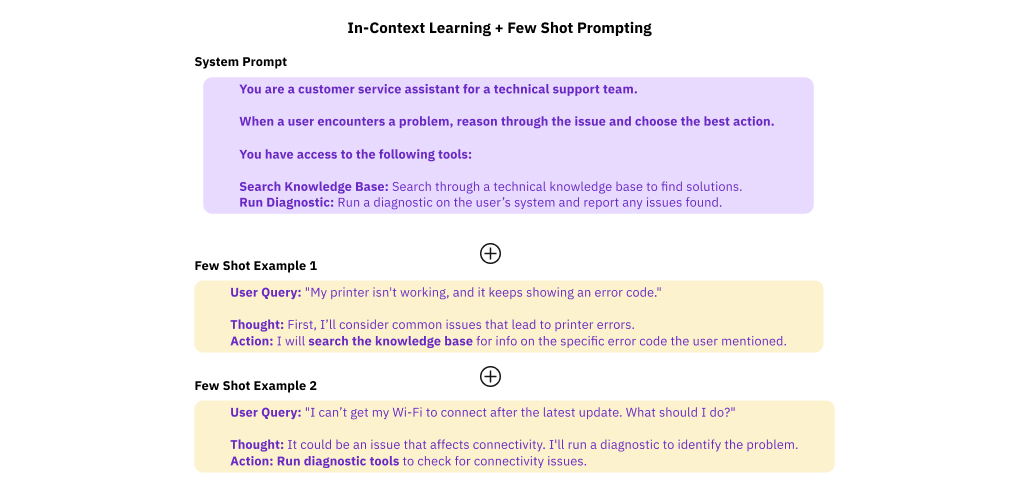

### 2.5 Constrained decoding or alternative strategies for increased control and reliability

ReAct can include multiple actions for an LLM to choose from, often requiring structured outputs for smooth execution. 

To improve reliability, techniques such as [constrained decoding](https://www.aidancooper.co.uk/constrained-decoding/) (e.g., JSON mode) can be used to ensure the LLM responses meet specified formats, which is particularly useful for infering tool parameter and establishing robustness in enterprise use cases.

Alternative strategies such as post-processing outputs using LLMs fine-tuned for reformatting (e.g., slot-filling) can also be helpful.

If constrained decoding isn’t available, developers can combine in-context learning with stop tokens and delimiters to guide LLM behavior.

By analyzing intermediate data generated by the LLM, developers can identify patterns that yield consistent, successful outcomes—an essential practice for any robust ReAct implementation.

These techniques can also enable developers to utilise smaller, more efficient models in place of larger, "do-it-all" models.

### Final considerations for ReAct

- Consider whether using ReAct is necessary for your use case. Can a more reproducible, deterministic workflow could suffice?
- Consider your tool definitions and whether some tools can be removed to simplify the space of ReAct based decision making. Always be descriptive in your tool names, tool uses and argument descriptions.
- Do you have sufficient test cases to represent an accurate evaluation to determine the effectiveness of ReAct for your use case?
- Consider using agentic frameworks only after determining the best performing ReAct prompts for your use case and your model availability.
- Consider how to handle cases where the algorithm gets stuck in a loop of using the same tool and does not finish its execution.
- Consider the underlying model's limitations: Is it good enough at reasoning?, Is it accurately loading in the tool parameters? etc. Also, smaller models are more limited in their capabilities compared to large models, although they are more cost efficient, they may need to be guided well and as a result end up using more ReAct iterations to achieve the desired intent. 

Now let us finally see ReAct in action!

## 3. Building ReAct from scratch: Augmenting LLMs for Basic Arithmetic. <a class="anchor" id="step3"></a>

We now develop a simple example to demonstrate the ideas described above. 

We want to augment our LLM to be able to do simple arithmetic (addition and multiplication) for not only mathematical expressions (e.g., 2 * 3) but also expressions in natural language (e.g., two times five).

**Q:** First, does it justify using ReAct? 

- Potentially we could use the LLM to turn the queries into a python program that could be executed to get an answer straight away. However, let us assume we don't have access to executable environment but just two tools for adding and multiplying numbers. In that case, different ways to verbalize expressions does not conform to a deterministic flow of execution - we need more dynamic execution to simplify and evaluate the expression. Under these assumptions, it is a potential candidate for using ReAct pattern. 

**Q:** Second, do we have data to evaluate ReAct performance? 

- Sure, we can generate some simple natural-language arithmetic expressions. We also have the tools needed which we will define during the course of the demonstration.

Before diving in to the code, the flow diagram below demonstrates the ReAct flow we are aiming to achieve for a simple multiplcation usecase.

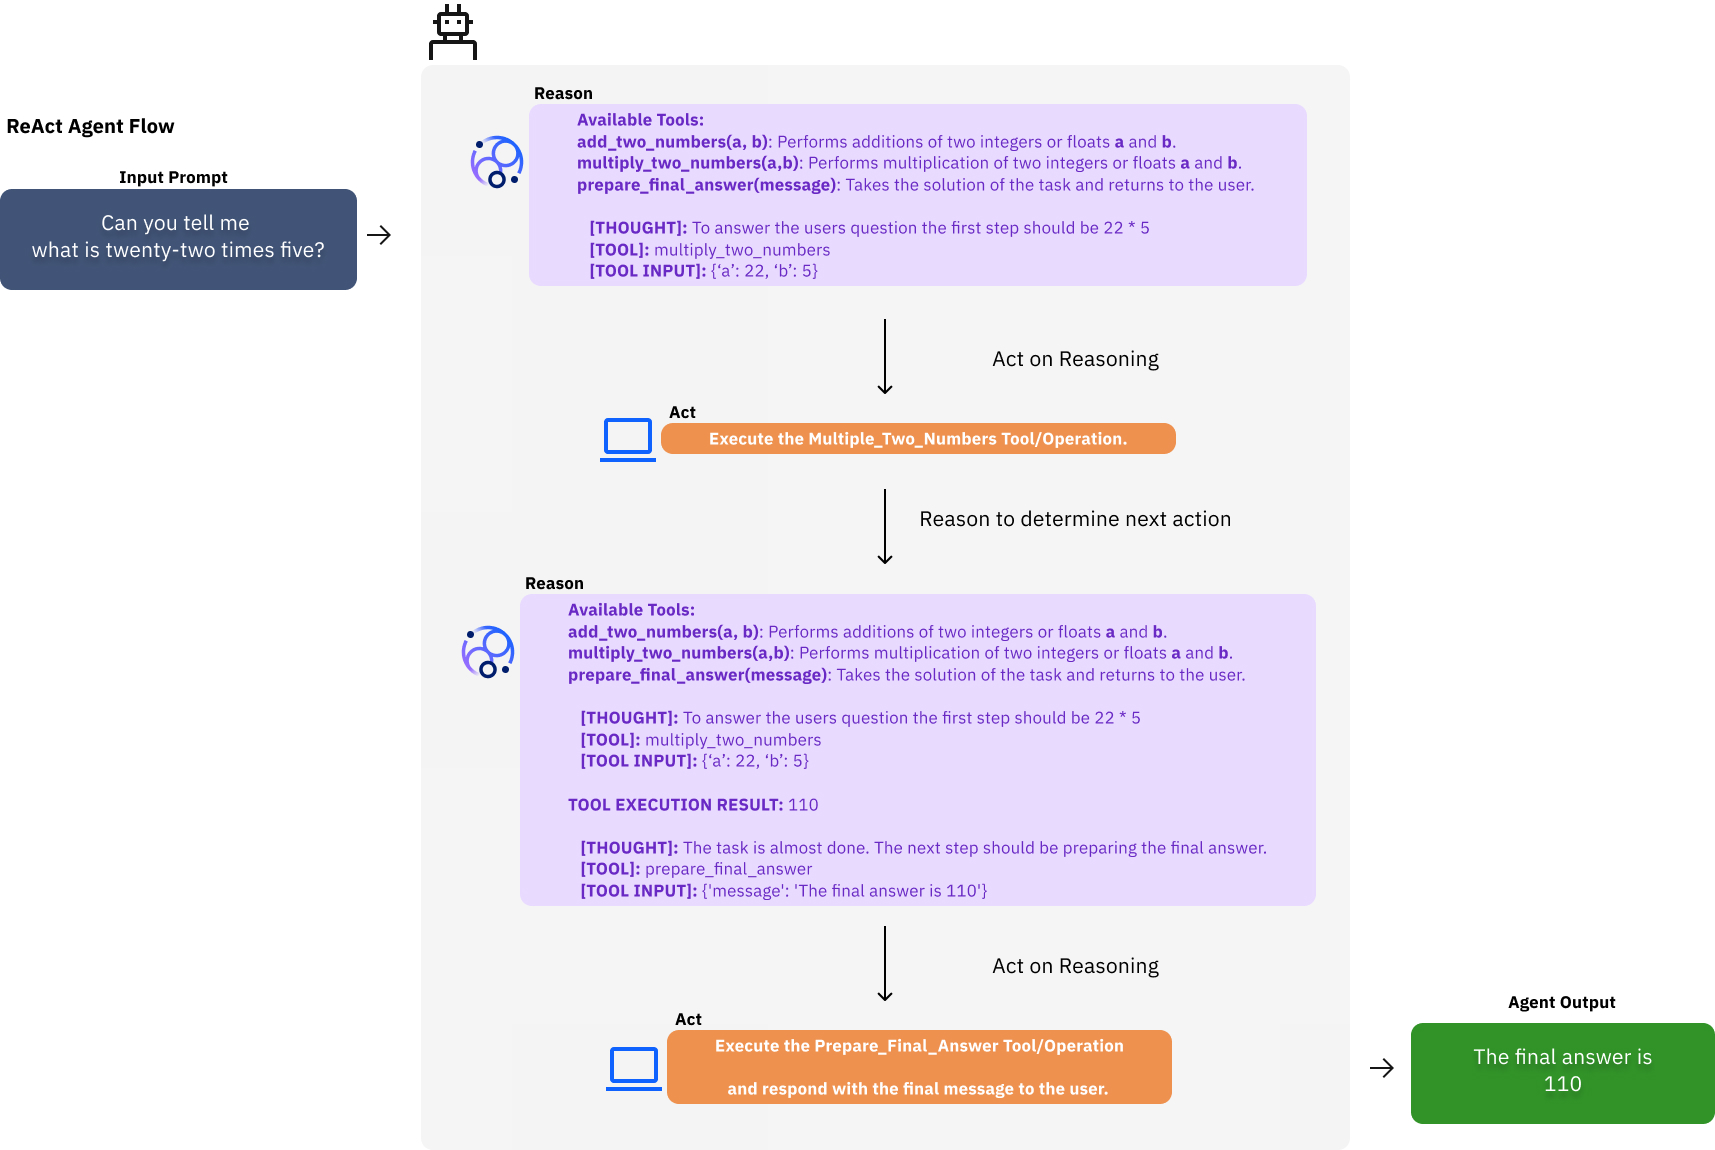

#### Step 0. Set up your environment

While you can choose from several tools, this tutorial is best suited for a Jupyter Notebook. Jupyter Notebooks are widely used within data science to combine code with various data sources such as text, images and data visualizations.

You can run this notebook in [Colab](https://colab.research.google.com/), or download it to your system and [run the notebook locally](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started_with_Jupyter_Locally/Getting_Started_with_Jupyter_Locally.md).

To avoid Python package dependency conflicts, we recommend setting up a [virtual environment](https://docs.python.org/3/library/venv.html).

Note, this notebook is compatible with Python 3.11.10 and well as Python 3.10.12, the default in Colab at the time of publishing this tutorial. To check your python version, you can run the !python --version command in a code cell.

We will be using [Replicate](https://replicate.com/) to access the models in this notebook. Have a look at the example [here](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb) to get started with Replicate and get a small amount of credit to experiment with this notebook.

Now we will install the dependencies to run this example. 

In [ ]:
# installations
%pip install -q git+https://github.com/ibm-granite-community/utils \
    langchain_community \
    langchain-huggingface \
    requests \
    python-dotenv \
    replicate

In [ ]:
from langchain_community.llms import Replicate
from ibm_granite_community.notebook_utils import get_env_var
from dotenv import load_dotenv
import json

load_dotenv()

REPLICATE_API_TOKEN = get_env_var('REPLICATE_API_TOKEN')


In [135]:
# setup model connection
model = Replicate(
    model="ibm-granite/granite-3.2-8b-instruct",
    replicate_api_token=REPLICATE_API_TOKEN,
    model_kwargs={
        "max_tokens": 2000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 200, # Set the minimum number of tokens to generate as output.
        "temperature": 0.75,
        "presence_penalty": 0,
        "frequency_penalty": 0,
    },
)

In [ ]:
# test model connection
prompt = """\
<|start_of_role|>user<|end_of_role|>\
Tell a story about a duck who likes french fries.<|end_of_text|>
<|start_of_role|>assistant<|end_of_role|>"""

response = model.invoke(prompt)
print(response)

### 3.1 Defining a well-specified narrow set of actions (i.e., tools)

Let us write the addition and multiplication tools and their arguments in a well-specified way: `add_two_numbers` and `multiply_two_numbers`. We are attempting to make it clear to the LLM that the tool can be used to add or multiply only two numbers at once (operating on two numbers at a time is the choice we made for tool design.) It may be possible that the LLM would infer only two numbers are operated on based on the function docstrings but reinforcing via good naming can only help.

We also design one auxiliary tool called `prepare_final_answer` which can be invoked by the LLM to signal the final action and format the output for the user. This will help us simplify the flow: it becomes streamlined to `thought-action-response (repeated)` making it easy to follow the structure.

Some tips:
- LLMs cannot overcome the weaknesses of tools. The tools should be well-defined and it should not be difficult to characterize when a tool would work and when it would not. Otherwise it could result in a less desirable user experience where the errors are introduced not only because of LLM's inherent weaknesses but also because of the tools. Moreover it becomes difficult to characterize what kind of tasks would pass or fail if the tools themselves are difficult to characterize. This again could lead to a developer applying band-aid guidelines in the system prompt and hoping that the LLM would follow the guidelines.
- Roles and responsibilities of tools are important: The tools should be **non-overlapping** as much as possible (or at least there should be non-overlapping categories of tools). This makes it easier to give guidelines to LLMs about tool usage.

In [ ]:
def add_two_numbers(a: float, b: float) -> float:
    """Performs addition of two numbers each of which could be an integer or a float.

    Args:
        a: First integer or float that is part of addition operation.
        b: Second integer or float that is part of addition operation.
    """
    return a + b


def multiply_two_numbers(a: float, b: float) -> float:
    """Performs multiplication of two numbers each of which could be an integer or a float.

    Args:
        a: First integer or float that is part of multiplication operation.
        b: Second integer or float that is part of multiplication operation.
    """
    return a * b

def prepare_final_answer(solution: str) -> str:
    """Takes the solution of the task and returns to the user.

    Args:
        solution: The final solution in well-paraphrased form.
    """
    return solution

def get_func_schema(func):
    return func.__doc__

In [ ]:
tools  = [add_two_numbers, multiply_two_numbers, prepare_final_answer]
schemas = [get_func_schema(t) for t in tools]
map_tool_name_to_schema = {k.__name__: v for k, v in zip(tools, schemas)}
map_tool_name_to_tool = {t.__name__: t for t in tools}

### 3.2 Defining an environment to execute actions 

These tools are quite safe to be invoked in a local containerized python environment. We are not using any dangerous `eval()` or such functionality to execute arbitrary expressions. Note that maybe there could still be vulnerabilities and it should be looked into carefully by the app developer.

### 3.3 Defining an alternating flow of reason and action starting with a user query

We have the following simple reason-action loop.

Note that we do not have explicit observation like in typical ReAct examples. Here we do not find the need for it, as the LLM can observe the status from looking at the result of the previous step, there's nothing deeper to observe or infer. We are designing in a way that the thinking or reasoning step would do the role of incorporating the tool responses as observations internally.

This implementation below is almost identical to the pseudo-code in the earlier sections.

**Note**: The subroutines in the function below will appear shortly afterwards in subsequent subsections.

In [ ]:
def reactor(query):
    num_steps = 0
    messages = initialize_messages(query, schemas)  # Initialize state
    while num_steps < 10:
        num_steps += 1

        # Get thoughts
        thought = get_thoughts(messages)
        print("Thought = ", thought)

        # Get action
        action = get_action(messages)
        print("Action = ", action)
        if action not in map_tool_name_to_tool:
            print('Chosen invalid action: more control needed over ReAct action selection')
            return

        # Get arguments for action
        args = get_args(messages)
        print("Args = ", args)

        # Get either the tool response or the final answer
        if not is_final_step(action):
            tool_response = map_tool_name_to_tool[action](**args)
            print("Tool execution result = ", tool_response)
            messages.append({'role': 'user', 'content': f'response: {tool_response}'})
        else:
            tool_response = map_tool_name_to_tool[action](**args)
            return tool_response
    else:
        raise Exception("Could not terminate within given number of steps")

### 3.4 Setting up the initial context and in-context examples 

In [140]:
def initialize_context(messages, schemas):
    messages.extend([
        {'role': 'system', 'content': 'This is an arithmetic task to be solved in multiple steps with using only the provided tools with appropriate order of invoking the tools. Take one step at a time and invoke one tool in each step. The final answer must also be given via invoking a tool.'},
        {'role': 'assistant', 'content': f'I will attempt to use the following tools, one each in step:\n {schemas}'}
    ])


We write an `initialize_messages` function mentioned in the above `reactor` function which will also add some in-context demonstrations. Notice that we have a highly predictable structure to guide the LLM: a task starts with a `begin_task` nessage, followed by the task. Afterwards there is the flow of reason-action-response until the LLM finds the final answer.

We have also added delimiters for thoughts, actions, and arguments to make it easy to guide the LLM and extract the responses.

In [141]:
def add_in_context_demos(messages):
    messages.extend([{'role': 'user', 'content': 'begin_task'},
        {'role': 'user', 'content': '91 * ((276 * 394) + 2398 + 79243434)'},
        {'role': 'assistant', 'content': '<scratchpad> The first step should be 276 * 394 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> multiply_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 276, "b": 394 } </args>'},
        {'role': 'user', 'content': 'response: 108744'},
        {'role': 'assistant', 'content': '<scratchpad> The next step should be 108744 + 2398 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> add_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 108744, "b": 2398 } </args>'},
        {'role': 'user', 'content': 'response: 111142'},
        {'role': 'assistant', 'content': '<scratchpad> The next step should be 111142 + 79243434 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> add_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 111142, "b": 79243434 } </args>'},
        {'role': 'user', 'content': 'response: 79354576'},
        {'role': 'assistant', 'content': '<scratchpad> The next step should be 91 * 79354576 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> multiply_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 91, "b": 79354576 } </args>'},
        {'role': 'user', 'content': 'response: 7221266416'},
        {'role': 'assistant', 'content': '<scratchpad> The task is almost done. The next step should be preparing the final answer </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> prepare_final_answer </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "solution": "The final answer is 7221266416" } </args>'},
        {'role': 'user', 'content': 'end_task'},
        {'role': 'user', 'content': 'begin_task'},
        {'role': 'user', 'content': 'What is (4354 plus 678.2) \\times 967?'},
        {'role': 'assistant', 'content': '<scratchpad> The first step should be 4354 + 678.2 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> add_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 4354, "b": 678.2 } </args>'},
        {'role': 'user', 'content': 'response: 5032.2'},
        {'role': 'assistant', 'content': '<scratchpad> The next step should be 5032.2 * 967 </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> multiply_two_numbers </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "a": 5032.2, "b": 967 } </args>'},
        {'role': 'user', 'content': 'response: 4866137.4'},
        {'role': 'assistant', 'content': '<scratchpad> The task is almost done. The next step should be preparing the final answer </scratchpad>'},
        {'role': 'user', 'content': 'get_action'},
        {'role': 'assistant', 'content': '<action> prepare_final_answer </action>'},
        {'role': 'user', 'content': 'get_arguments_for_action'},
        {'role': 'assistant', 'content': '<args> { "solution": "The final answer is 4866137.4" } </args>'}, 
        {'role': 'user', 'content': 'end_task'},
        {'role': 'user', 'content': 'begin_task'},
    ])

def initialize_messages(query, schemas):
    messages = []
    initialize_context(messages, schemas)
    add_in_context_demos(messages)
    messages.append({'role': 'user', 'content': query})
    return messages

### 3.5 Utilizing strategies for increased control and reliability

Below we demonstrate three functions which are used to query the LLM for getting its thoughts, actions, and arguments for the action. We make use of stop tokens following the structure of in-context examples above. Note that if you have constrained decoding available then it could be implemented in many different ways: for examples, `get_thoughts` could use regex, `get_action` could use enums to enforce the set of actions (or `guided_choice` if you are familiar with vLLM), and `get_args` could use json grammars.

**Note:** This notebook demonstrates writing the ReAct implementation from scratch and refrains from using any tool-use specific post-training features that may be present in the base model. For example in a real-world usage of the `granite` models for the ReAct algorithm, a custom `<|tool_call|>` token can be used to leverage the model's preferred response structure. You can find more details on this in the [Granite Technical Report](https://github.com/ibm-granite/granite-3.0-language-models/blob/main/paper.pdf).

In [ ]:
def get_formatted_prompt(messages: list[dict]):
    formatted_prompt = ""
    for message in messages:
        role = message["role"]
        content = message["content"]
        formatted_prompt += f"<|start_of_role|>{role}<|end_of_role|>{content}<|end_of_text|>"

    return formatted_prompt

def get_thoughts(messages):
    prompt = get_formatted_prompt(messages)
    response = model.invoke(prompt, stop_sequences="</scratchpad>")
    
    messages.append({'role': 'assistant', 'content': response + '</scratchpad>'})
    thoughts = response.replace('<scratchpad>', '').replace('</scratchpad>', '').strip()
    
    return thoughts

def get_action(messages):
    messages.append({'role': 'user', 'content': 'get_action'})
    
    prompt = get_formatted_prompt(messages)
    response = model.invoke(prompt, stop_sequences="</action>")
    
    messages.append({'role': 'assistant', 'content': response + '</action>'})
    action = response.replace('<action>', '').replace('</action>', '').strip()
    
    return action

def get_args(messages):
    messages.append({'role': 'user', 'content': 'get_arguments_for_action'})
    
    prompt = get_formatted_prompt(messages)
    response = model.invoke(prompt, stop_sequences="</args>")
    
    messages.append({'role': 'assistant', 'content': response + '</args>'})
    args = json.loads(response.replace('<args>', '').replace('</args>', '').strip())
    
    return args


def is_final_step(action):
    return action == 'prepare_final_answer'

## 3.6 Showtime!

#### Some simple queries

Comment and execute as you like - we only execute the last query here.

In [ ]:
query = 'What is (8 + 4) * 4?'
query = 'Twenty-two times Five'
query = '(1 + (2 + (3 + (4 + 5))))'
query = '(290 + 345 + 2567) times 95 = ?'

print('\n', '-'* 10); result = reactor(query); print(result, '\n', '-'* 10)

#### A little more involved natural language queries

We get reasonable success here. Again, we execute only the last query, other queries are for the reader to try out.

In [ ]:
query = 'What do you get when you multiply 95 by 34 and then add 546?'
query = 'What is the sum of numbers in the list [11, 14, 17, 20]?'
query = 'What is the product of all the integers between 40 and 45 inclusive of both ends?'
query = 'If two couples have four children per couple then how many children there will be among them?'

print('\n', '-'* 10); result = reactor(query); print(result, '\n', '-'* 10)

#### More complex queries that could be hit or miss

We have not designed our ReAct pipeline with more complex queries involving model consulting internal knowledge or understanding nuances. If such queries are expected to be the part of use-cases then a developer could instruct the model through the initial context or few-shot examples for some coverage.

More advanced pipelines could also be considered where there'd be a planner module and a reviewer module which would attempt to transform the query into a correct expression that our ReAct implementation is equipped to evaluate.

This demonstrates that even a seemingly simple use case could turn out to be challenging due to unanticipated complexity.

In [ ]:
# Potentially hallucinates a tool - needs adapting system prompt to identify when tools are missing to handle queries or constrained decoding or other strategies to choose a valid tool.
query = 'What is the summation of arithmetic progression starting at 11 and ending at 20 with difference of 3?'

# Trick question which causes failure:
# If this is a possible use-case, then add in in-context example to identify how to handle such cases or consider more fine-grained tools.
# However, possibly there would always be some trick questions that'd stump the pipeline. Augment the ReAct agent with observability and monitoring tools to capture these cases.
query = 'What do you get when you add three mangoes with two bananas?'

print('\n', '-'* 10); result = reactor(query); print(result, '\n', '-'* 10)

A developer might wonder if the complex queries might pass if we did not enforce ReAct pattern. A fun observation is that the model passes the last question on its own without ReAct.

In [ ]:
model.invoke("What do you get when you add three mangoes with two bananas?")

#### Irrelevant queries: no guarantee what ReAct would do

If a model is given irrelevant queries to our use case then there's no guarantee what would happen since our pipeline has been prepared for arithmetic queries. Typically, a developer might want to do some "admissibility check" before sending a query to a ReAct instance. This admissibility check could be done with specialized LLMs or planning modules or classifiers if desired.

In [ ]:
# Understands that there's no tool available.
query = 'What\'s the weather today?'

# Hallucinates a tool
query = 'What is cosine of 37 degrees multiplied by sine of 63 degrees'

print('\n', '-'* 10); result = reactor(query); print(result, '\n', '-'* 10)

# 4. Recap  <a class="anchor" id="step4"></a>

So far, we have done the following::
- We discussed when we should consider using ReAct and when we should stick to more deterministic execution patterns (Section 1).
- We went over the essentials of ReAct design pattern (Section 2)
- We did a ground-up implementation of ReAct to augment LLM with simple arithmetic capabilities (Section 3). We saw that underlying ReAct flow is just a loop. This loop can be implemented in several different ways. Popular prompts combine Thought, Action, Observations in a single LLM response, however it is completely up to the developer and importantly the use-case to reimagine this. We showed an implementation where the inside of loop is broken into sub-steps.

Now we will go to explain how this could be optimized further and also highlight some typical sources of errors.

# 5. Advanced Reading  <a class="anchor" id="step5"></a>

ReAct at its basis is an algorithm or pattern for prompting the underlying LLMs to assist in Reasoning and Action taking for agentic workflows. When implemented in its basic configuration as demonstrated in this tutorial, many simplistic use cases can be enabled and can be used to showcase powerful demos.

For more complex use cases however, there are multiple considerations and optimizations we can make to build a more robust, production ready agent which utilizes ReAct. 

In this section we will demonstrate some of the advanced problems and solutions you can leverage to build a more accurate, observable and production ready ReAct implementation.

## 5.1 Improving accuracy by utilizing specialized LLMs

A ReAct implementation can be enhanced by leveraging different models for different tasks. The use of specialized models (fine-tuned or not) offer a means to improve accuracy of the overall agent by allocating specifics tasks to models that custom built for those tasks.

For example:

1. If the ReAct implementation has decomposed the task of action and parameter selection into to two seperate interactions with the underlying LLMs (like we have done), then a further enhancement could be to utilize a specialized code model for the parameter selection. 
2. If your selected action or tool is a SQL focused tool, then using a language model customized for SQL query generation may exhibit better accuracy then using a general purpose LLM.
3. If you have a domain fine-tuned model suitable for your use cases, using that as the action selection model may offer better perfomance. 

Utilizing different models for different sub-tasks can also offer **cost improvements** as the reliance on larger, "do-it-all" models can be mitigated and instead be replaced by smaller, specialized models.

Note: Building your ReAct utilizing multiple models by some definitions means that you have built a multi-agent architecture as specialized tasks are allocated to seperate models with custom system prompts.

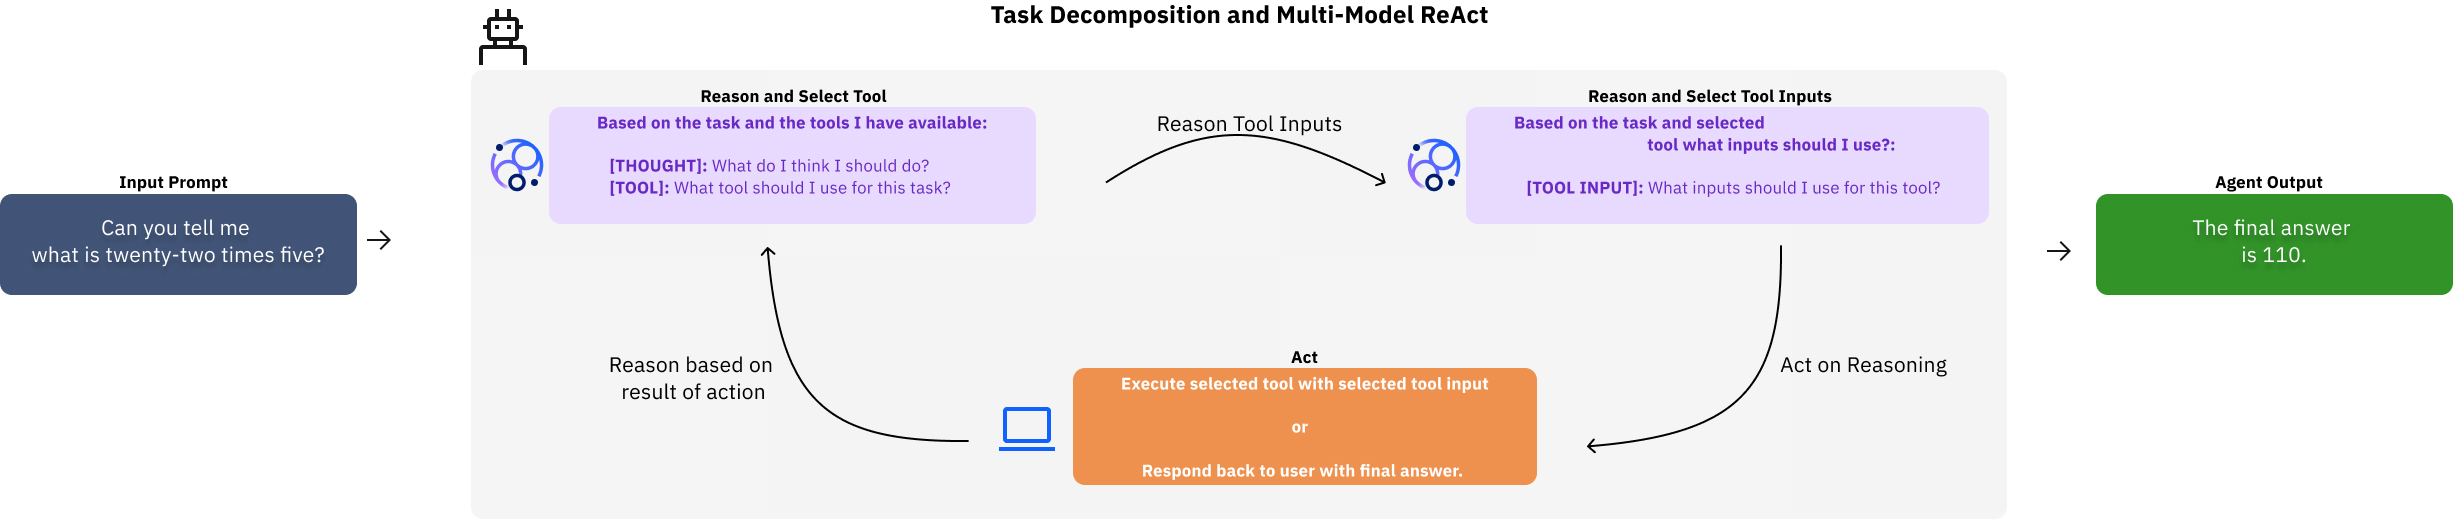

## 5.2 Improving accuracy by augmenting tool selection and utilization

When your ReAct implementation is equipped with many tools (or possible actions) the agent may be more likely to select the wrong tool for a given task. Similarly, the complexity of different tools can impact the accurate utilization of the relevant tools. 

In this section we cover some strategies to augment ReAct with patterns such as Retrieval Augmented Generation (RAG) and iterative parameter inference to improve the accuracy of agents for more complex use cases. 

### 5.2.1 Utilizing RAG for tool filtering

When an agent has access to many tools, not all of them may be relevant for a given task or prompt. For example to answer a mathematical query, there is no need to showcase the presence of weather focused tools. To improve the liklihood of selecting the right tools for the task, we can filter the list of tools for the agent to pick from, based on the current task. This pattern extends ReAct by performing RAG on the list of available tools before invoking the Reasoning and Action taking within the agent. 

We provide example flow diagram and an example code snippet to demonstrate Tool RAG in action. 

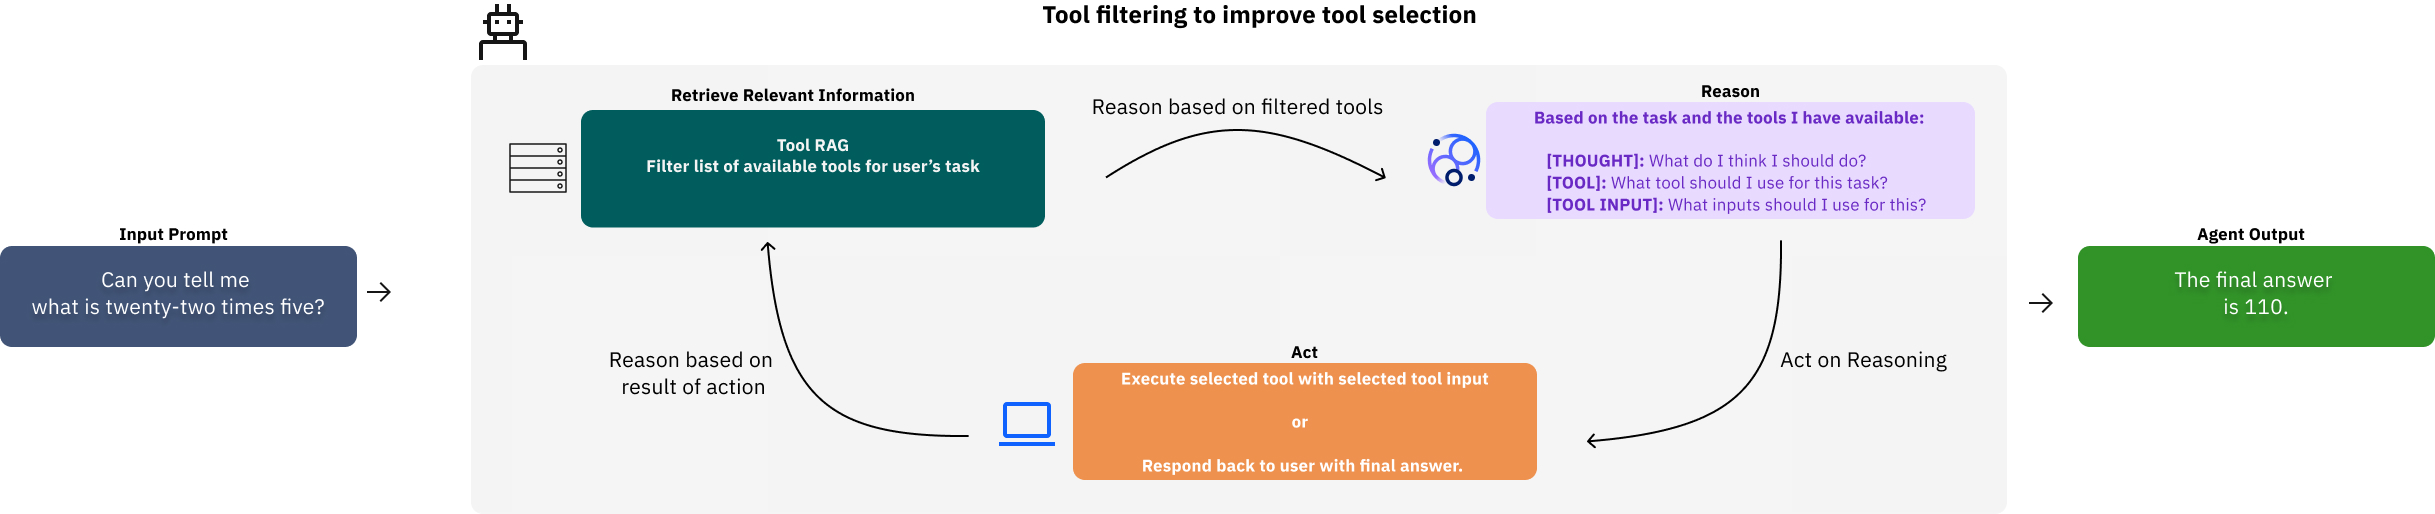


In [ ]:
# Example of RAG for tool filtering

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders.telegram import text_to_docs

# Retrieve embedding model from HuggingFace
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
tool_name_and_descriptors = [f"{tool_name}: {schema}" for tool_name, schema in map_tool_name_to_schema.items()]
print("All Available Tools:", "\n -", "\n - ".join(tool_name_and_descriptors))

vector_store = InMemoryVectorStore.from_documents(
    documents=text_to_docs(tool_name_and_descriptors),  
    embedding=embedding_model, 
    collection_name="tool_db"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 1})

prompt = "What is the sum of 5 and 10?"

filtered_tool_for_prompt = retriever.invoke(prompt)

print("\nGiven Prompt:\n", prompt)
print("\nFiltered Tool via RAG:\n -", filtered_tool_for_prompt[0].page_content)

### 5.2.2 Iterative loops for tool parameter inference

At times in enterprise settings, tools may come with complex schemas for input parameters. In a typical ReAct implementation, both the action and action/tool inputs are inferred in a single round of prompting. For tools with complex schemas, key parameters can be missed or inaccurately loaded by the agent. 

To remediate this point of failure, we can take a more iterative approach. Like we have done in this notebook, we can utilise techniques where the action selection and parameter selection for an action are performed separately to improve accuracy. 

Beyond that, we can also guide the LLM to load in parts of the schema in chunks to improve focus. Iteratively prompting an LLM to build up a completely loaded parameter set for tool invocation, we can also utilise reflection or repeated prompting to load in parameters which are required but being incorrectly loaded or ignored. 

### 5.2.3 Tool response filtering for context management

Similarly to how complex tool input parameters can cause the agents to go wrong, complex tool responses can pollute the agent's history with meaningless information and lead to hallucinations in future reasoning and acting iterations.

After executing different tools/actions, the ReAct pattern relies on the tool/action execution results (also sometimes called `Observations`) to more accurately select the next best action. 

Depending on your tool design and its complexity, the tool response could be large and only some of the information could be relevant. Therefore, a possible optimization is pre-processing action execution results to keep only relevant information before loading them into the agent context. When using smaller models or models with smaller context windows, focusing the context which is presented to the models can improve the accuracy and relevance of the model's responses. 

## 5.3 Expert-in-the-loop validation and correction patterns

A ReAct implementation can also involve patterns for human and agent collaboration. The basic ReAct algorithm is completely dynamic and acts like a magic box for the end user. For simple use cases and prompts this magic box performs well, but for more complex tasks with more complex tooling failures are imminent and fails to deliver real world value to the end user.

Expert-in-the-loop patterns can be implemented to involve the end user in some of the following ways:

- Inspecting and validating the actions and parameters inferred by the agent
- Correcting the actions and parameters inferred by the agent
- Asking the user to input parameters which are too complex for the agent to infer
- Asking the user to correct parameters when action execution goes wrong
- Offering the ability to inspect the complete action responses to validate the correctness of the tools being used

These patterns can be facilitated via simple UI/API features and elevate the end user experience by encouraging a "semi-autonomous" mode of operation for the agent which can help deliver value for use cases which are too complex for the agent to complete on it's own.

The diagram below demonstrates an extension of ReAct to incorporate the expert-in-the-loop.


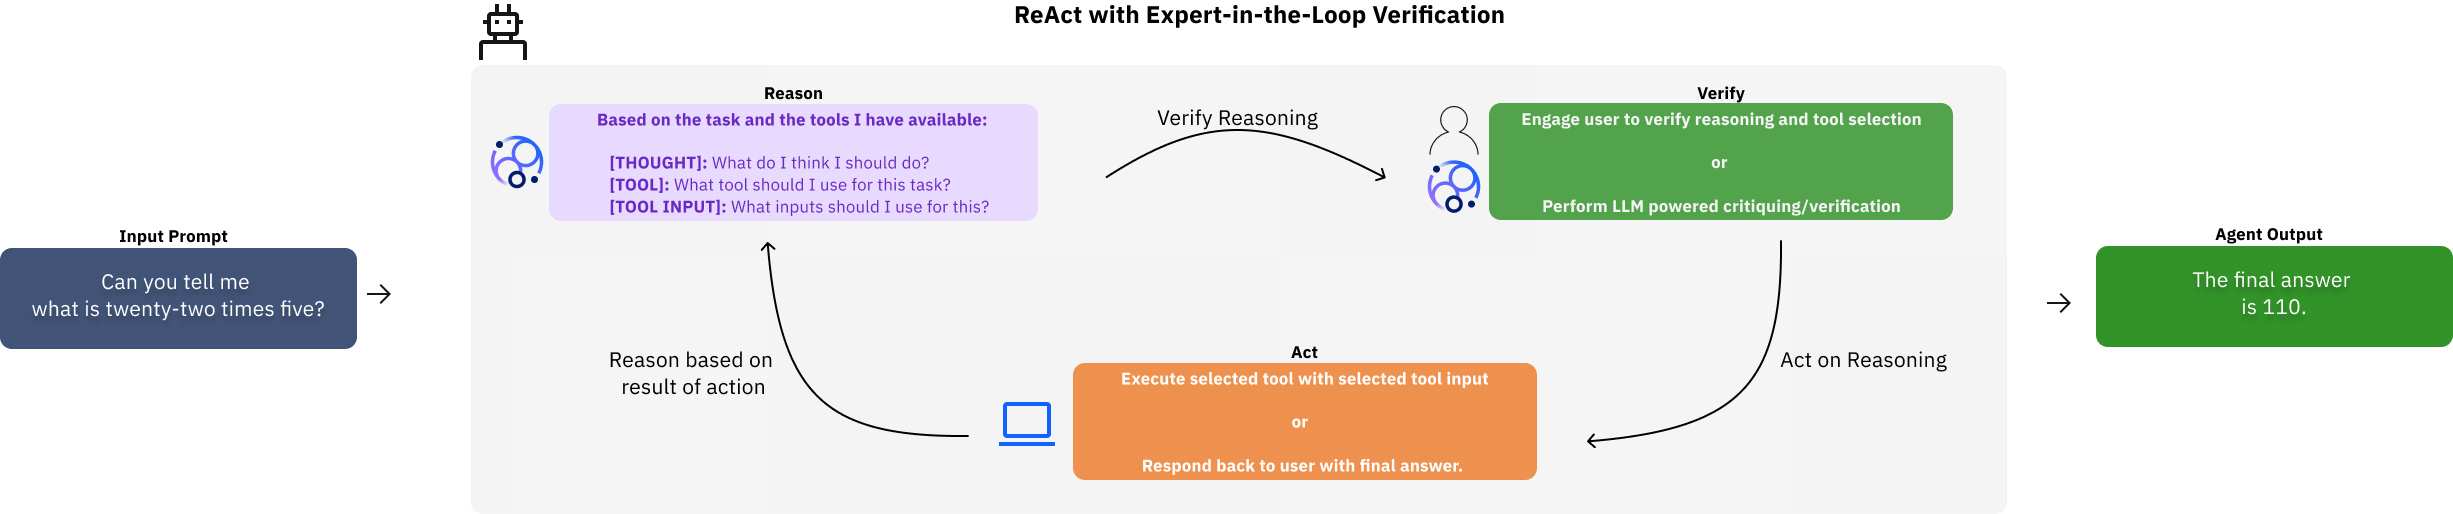

#### Footnotes

\[1\] If you are reading this with the background that popular ReAct patterns contain iterations over reason, action, and observation - we are combining reason and observation together in the reason section for the sake of simplicity. Indeed, ReAct acronym is REason and ACTion. A use-case specific implementation of ReAct can choose to implement observations separately or as a part of reasoning step.


Copyright © 2025 IBM. 
